## Mendeley datasets download via API

Get your Mendeley API token by registering an app here:

https://dev.mendeley.com/myapps.html

## Environment setup

In [55]:
import requests
from requests.auth import HTTPBasicAuth
from io import BytesIO
import os
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
import random
from IPython.display import clear_output

ROOT = ".." # Adjust to repository root

from dotenv import load_dotenv
DOTENV_PATH = os.path.join(ROOT,"../../apis/.env") # Adjust to .env file location

if load_dotenv(DOTENV_PATH):
    abs_path = os.path.abspath(DOTENV_PATH)
    drive, rel = os.path.splitdrive(abs_path)
    parts = rel.strip(os.sep).split(os.sep)
    masked = parts.copy()
    masked_parts = 1  # adjust to mask parts of your path
    max_maskable = max(0, len(parts) - 2)
    for i in range(min(masked_parts, max_maskable)):
        idx = len(parts) - 3 - i
        masked[idx] = "***"
    prefix = f"{drive}{os.sep}" if drive else (os.sep if abs_path.startswith(os.sep) else "")
    print(f"Loaded .env from {prefix}{os.sep.join(masked)}")
else:
    print("Failed to load .env file.")

CLIENT_ID = os.getenv("MENDELEY_CLIENT_ID")
CLIENT_SECRET = os.getenv("MENDELEY_CLIENT_SECRET")

def mask_token(token, unmasked_chars=3):
    return token[:unmasked_chars] + '*' * (len(token) - unmasked_chars*2) + token[-unmasked_chars:]
print(f"CLIENT_SECRET: {mask_token(CLIENT_SECRET)}")

Loaded .env from c:\Users\david\***\apis\.env
CLIENT_SECRET: hF8**********r63


## Worldwide Electricity Load Dataset

Ullah, Md Habib; Reza, Sayed Mohsin; Khan, Abdullah Al Ahad; Salekin, Siraj Us; Al-Bayati, Ali M. S.; Babaiahgari, Bhanu; Romero, David González; Molina, Jesús Rodríguez (2026), “Worldwide Electricity Load Dataset ”, Mendeley Data, V1, doi: 10.17632/ybggkc58fz.1

https://data.mendeley.com/datasets/ybggkc58fz/1

In [21]:
DATASET_ID = "ybggkc58fz"
DATASET_VERSION = "1"

TOKEN_URL = "https://api.mendeley.com/oauth/token"
DATASET_URL = f"https://api.mendeley.com/datasets/{DATASET_ID}"

# obtain access token
token_resp = requests.post(
    TOKEN_URL,
    data={"grant_type": "client_credentials", "scope": "all"},
    auth=HTTPBasicAuth(CLIENT_ID, CLIENT_SECRET),
)
token_resp.raise_for_status()
access_token = token_resp.json()["access_token"]

# access dataset metadata
headers = {
    "Authorization": f"Bearer {access_token}",
    "Accept": "application/vnd.mendeley-public-dataset.1+json",
}
params = {"version": DATASET_VERSION}

dataset_resp = requests.get(DATASET_URL, headers=headers, params=params)
dataset_resp.raise_for_status()

print(dataset_resp.json()["name"], '\n')
print(textwrap.fill(dataset_resp.json()["description"], width=120))

weld_data = dataset_resp.json()

print("\nNumber_of_files:", len(weld_data.get("files", [])), "\n")

weld_files = weld_data.get("files", [])
preview_names = ", ".join(file["filename"] for file in weld_files[:26]) + "..."
print(textwrap.fill(preview_names, width=120))

Worldwide Electricity Load Dataset  

This dataset provides a comprehensive, global-scale collection of time-series electricity load data aggregated from
major power markets across Asia, Europe, North America, and Oceania. It captures system-level demand profiles at
consistent temporal resolution, enabling detailed analysis of consumption patterns, peak-demand behavior, and seasonal
variability across regions. The dataset is structured in a standardized and harmonized format to support load
forecasting, cross-market comparative studies, and data-driven research in power system planning, operation, and energy
market analytics.

Number_of_files: 489 

Additional_Information.csv, Australia_AEMO_2006.csv, Australia_AEMO_2007.csv, Australia_AEMO_2008.csv,
Australia_AEMO_2009.csv, Australia_AEMO_2010.csv, Australia_AEMO_2011.csv, Australia_AEMO_2012.csv,
Australia_AEMO_2013.csv, Australia_AEMO_2014.csv, Australia_AEMO_2015.csv, Australia_AEMO_2016.csv,
Australia_AEMO_2017.csv, Australia_AEMO

Exploring file contents (run this cell multiple times to explore files at random):

In [25]:
random_file = weld_files[random.randint(1, len(weld_files)-1)]
print("\nRandom file preview:", random_file["filename"])
content = random_file.get("content_details", {})
download_url = content.get("download_url")
print("Download URL:", download_url)

r = requests.get(download_url, stream=True, timeout=10)
print("Response status code:", r.status_code)

preview_df = pd.read_csv(BytesIO(r.content))
display(preview_df.head(5))
print("...")
display(preview_df.tail(5))


Random file preview: USA_CAISO_2024.csv
Download URL: https://data.mendeley.com/public-files/datasets/ybggkc58fz/files/b63aac35-5a39-491b-98de-79de63eec073/file_downloaded
Response status code: 200


,Timestamp,CAISO
0,2024-01-01T00:00:00,21598.0
1,2024-01-01T01:00:00,21000.0
2,2024-01-01T02:00:00,20396.0
3,2024-01-01T03:00:00,19911.0
4,2024-01-01T04:00:00,19743.0


...


,Timestamp,CAISO
8190,2024-12-31T19:00:00,25087.0
8191,2024-12-31T20:00:00,24354.0
8192,2024-12-31T21:00:00,23767.0
8193,2024-12-31T22:00:00,23011.0
8194,2024-12-31T23:00:00,22143.0


Downloading the full dataset via Mendeley API:

Downloading the full dataset via Mendeley API:

In [26]:
DATASET_DIR = os.path.join(ROOT, "datasets", "weld")
PKL_DIR = os.path.join(ROOT, "pkl", "weld")
timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
LOG_PATH = os.path.join(ROOT, "datasets", "weld", "logs", f"{timestamp}_download_errors.log")

os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(PKL_DIR, exist_ok=True)

In [27]:
results = []

weld_files = weld_data.get("files", [])

for f in weld_files:
    file_name = f.get("filename")
    content = f.get("content_details", {})

    if not file_name or content.get("content_type") != "text/csv":
        continue

    file_path = os.path.join(DATASET_DIR, file_name)
    pickle_file = os.path.join(PKL_DIR, file_name.replace(".csv", ".pkl"))

    try:
        # skip download if CSV already exists
        if not os.path.exists(file_path):
            download_url = content.get("download_url")
            if not download_url:
                continue

            r = requests.get(download_url, stream=True, timeout=10)
            r.raise_for_status()

            with open(file_path, "wb") as fh:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:
                        fh.write(chunk)

        df = pd.read_csv(file_path)
        record_count = len(df)

        results.append({"csv_name": file_name, "record_count": record_count})
        print(f"Processed {file_name} with {record_count} records.")
        clear_output(wait=True)

        if "Timestamp" in df.columns:
            df["Timestamp"] = pd.to_datetime(df["Timestamp"])

        os.makedirs(os.path.dirname(pickle_file), exist_ok=True)
        df.to_pickle(pickle_file)

    except Exception as e:
        with open(LOG_PATH, "a", encoding="utf-8") as log:
            log.write(f"{file_name} | {type(e).__name__} | {e}\n")
        continue

csvs_df = pd.DataFrame(results)
csvs_df["pkl_name"] = csvs_df["csv_name"].str.replace(".csv", ".pkl")

display(csvs_df)

list_file_name = "0_weld_files_list.pkl"
csvs_df.to_pickle(os.path.join(PKL_DIR, list_file_name))
print(f"Saved file list to {os.path.join(PKL_DIR, list_file_name)}")

,csv_name,record_count,pkl_name
0,Additional_Information.csv,42,Additional_Information.pkl
1,Australia_AEMO_2006.csv,17519,Australia_AEMO_2006.pkl
2,Australia_AEMO_2007.csv,17520,Australia_AEMO_2007.pkl
3,Australia_AEMO_2008.csv,17568,Australia_AEMO_2008.pkl
4,Australia_AEMO_2009.csv,17520,Australia_AEMO_2009.pkl
...,...,...,...
484,USA_SPP_2021.csv,8758,USA_SPP_2021.pkl
485,USA_SPP_2022.csv,8749,USA_SPP_2022.pkl
486,USA_SPP_2023.csv,8757,USA_SPP_2023.pkl
487,USA_SPP_2024.csv,8782,USA_SPP_2024.pkl


Saved file list to ..\pkl\weld\0_weld_files_list.pkl


## Global Day-Ahead Electricity Price Dataset

Ullah, Md Habib; Reza, Sayed Mohsin; Gundapaneni, Lasya Madhuri; Balachander, Pranav; Babaiahgari, Bhanu; Khan, Abdullah Al Ahad (2025), “Global Day-Ahead Electricity Price Dataset”, Mendeley Data, V3, doi: 10.17632/s54n4tyyz4.3
https://data.mendeley.com/datasets/s54n4tyyz4/3

In [28]:
DATASET_ID = "s54n4tyyz4"
DATASET_VERSION = "3"

TOKEN_URL = "https://api.mendeley.com/oauth/token"
DATASET_URL = f"https://api.mendeley.com/datasets/{DATASET_ID}"

# obtain access token
token_resp = requests.post(
    TOKEN_URL,
    data={"grant_type": "client_credentials", "scope": "all"},
    auth=HTTPBasicAuth(CLIENT_ID, CLIENT_SECRET),
)
token_resp.raise_for_status()
access_token = token_resp.json()["access_token"]

# access dataset metadata
headers = {
    "Authorization": f"Bearer {access_token}",
    "Accept": "application/vnd.mendeley-public-dataset.1+json",
}
params = {"version": DATASET_VERSION}

dataset_resp = requests.get(DATASET_URL, headers=headers, params=params)
dataset_resp.raise_for_status()

print(dataset_resp.json()["name"], '\n')
print(textwrap.fill(dataset_resp.json()["description"], width=120))

daep_data = dataset_resp.json()

print("\nNumber_of_files:", len(daep_data.get("files", [])), "\n")

daep_files = daep_data.get("files", [])
preview_names = ", ".join(file["filename"] for file in daep_files[:26]) + "..."
print(textwrap.fill(preview_names, width=120))

Global Day-Ahead Electricity Price Dataset 

This dataset presents a unified, cross-continental time-series day-ahead electricity prices compiled from major
wholesale markets across Asia, Europe, North America, South America, and Oceania. The dataset offers a standardized
format that supports time-series forecasting and enables robust comparative analysis across diverse global electricity
markets.

Number_of_files: 506 

Additional_Information_by_Country.csv, Australia_AEMO_2006.csv, Australia_AEMO_2007.csv, Australia_AEMO_2008.csv,
Australia_AEMO_2009.csv, Australia_AEMO_2010.csv, Australia_AEMO_2011.csv, Australia_AEMO_2012.csv,
Australia_AEMO_2013.csv, Australia_AEMO_2014.csv, Australia_AEMO_2015.csv, Australia_AEMO_2016.csv,
Australia_AEMO_2017.csv, Australia_AEMO_2018.csv, Australia_AEMO_2019.csv, Australia_AEMO_2020.csv,
Australia_AEMO_2021.csv, Australia_AEMO_2022.csv, Australia_AEMO_2023.csv, Australia_AEMO_2024.csv,
Australia_AEMO_2025.csv, Austria_ENTSO-E_2015.csv, Austria_EN

Exploring file contents (run this cell multiple times to explore files at random):

In [36]:
random_file = daep_files[random.randint(1, len(daep_files)-1)]
print("\nRandom file preview:", random_file["filename"])
content = random_file.get("content_details", {})
download_url = content.get("download_url")
print("Download URL:", download_url)

r = requests.get(download_url, stream=True, timeout=10)
print("Response status code:", r.status_code)

preview_df = pd.read_csv(BytesIO(r.content))
display(preview_df.head(5))
print("...")
display(preview_df.tail(5))


Random file preview: Latvia_ENTSO-E_2023.csv
Download URL: https://data.mendeley.com/public-files/datasets/s54n4tyyz4/files/b60ae7ad-5cc7-4467-84a6-71bbdf4c4c9e/file_downloaded
Response status code: 200


,Timestamp,Latvia
0,2023-01-01T00:00:00,2.01
1,2023-01-01T01:00:00,1.38
2,2023-01-01T02:00:00,0.09
3,2023-01-01T03:00:00,0.08
4,2023-01-01T04:00:00,0.05


...


,Timestamp,Latvia
8755,2023-12-31T19:00:00,59.99
8756,2023-12-31T20:00:00,40.99
8757,2023-12-31T21:00:00,53.83
8758,2023-12-31T22:00:00,55.49
8759,2023-12-31T23:00:00,40.01


Comparing load and price files:

In [49]:
filename = "Estonia_ENTSO-E_2023.csv"
daep_file = next(item for item in daep_files if item["filename"] == filename)
print('File in DAEP dataset: ', daep_file)
weld_file = next(item for item in weld_files if item["filename"] == filename)
print('File WELD dataset: ',weld_file)

File in DAEP dataset:  {'filename': 'Estonia_ENTSO-E_2023.csv', 'id': '65918d05-0ed9-4e54-9d64-023462cfe658', 'folder_id': 'e0d034a5-868f-4165-815a-cc7f0b7f5019', 'content_details': {'id': '0199ffe7-f32c-4904-b199-21528e2d8836', 'sha256_hash': '74fc577995295b41c1b32a3ab836399bbd7f19e8391ae0615786894d9a21e2be', 'content_type': 'text/csv', 'size': 238402, 'created_date': '2025-08-20T01:33:33.741Z', 'download_url': 'https://data.mendeley.com/public-files/datasets/s54n4tyyz4/files/65918d05-0ed9-4e54-9d64-023462cfe658/file_downloaded', 'view_url': 'https://data.mendeley.com/public-files/datasets/s54n4tyyz4/files/65918d05-0ed9-4e54-9d64-023462cfe658/file_viewed', 'download_expiry_time': '2126-01-05T17:24:01.217396523Z'}, 'metrics': {'downloads': 0, 'previews': 0}, 'size': 238402, 'status': 'COMPLETED'}
File WELD dataset:  {'filename': 'Estonia_ENTSO-E_2023.csv', 'id': 'ce485f3a-b69c-45ae-8c1f-7e2d0cdac7ea', 'folder_id': '9c71fc5a-b3c4-4c25-8e1f-dde988f34561', 'content_details': {'id': '1e847

Download URL DAEP: https://data.mendeley.com/public-files/datasets/s54n4tyyz4/files/65918d05-0ed9-4e54-9d64-023462cfe658/file_downloaded
Download URL WELD: https://data.mendeley.com/public-files/datasets/ybggkc58fz/files/ce485f3a-b69c-45ae-8c1f-7e2d0cdac7ea/file_downloaded
DAEP request: 200
WELD request: 200


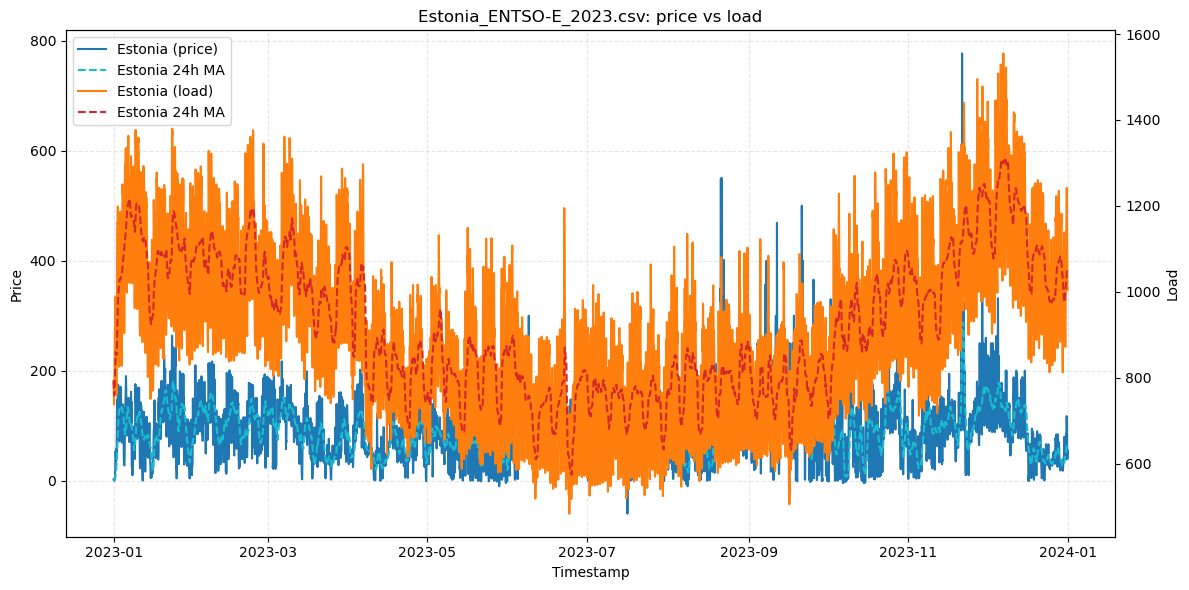

In [56]:
daep_content = daep_file.get("content_details", {})
download_url_daep = daep_content.get("download_url")

weld_content = weld_file.get("content_details", {})
download_url_weld = weld_content.get("download_url")
print("Download URL DAEP:", download_url_daep)
print("Download URL WELD:", download_url_weld)

r_daep = requests.get(download_url_daep, stream=True, timeout=10)
print("DAEP request:", r_daep.status_code)
r_weld = requests.get(download_url_weld, stream=True, timeout=10)
print("WELD request:", r_weld.status_code)

plot_df_daep = pd.read_csv(BytesIO(r_daep.content))
plot_df_daep["Timestamp"] = pd.to_datetime(plot_df_daep["Timestamp"], errors="coerce")

plot_df_weld = pd.read_csv(BytesIO(r_weld.content))
plot_df_weld["Timestamp"] = pd.to_datetime(plot_df_weld["Timestamp"], errors="coerce")

price_col = plot_df_daep.select_dtypes(include="number").columns[0]
load_col = plot_df_weld.select_dtypes(include="number").columns[0]

ma_price_col = f"{price_col}_MA24"
plot_df_daep[ma_price_col] = plot_df_daep[price_col].rolling(window=24, min_periods=1).mean()

ma_load_col = f"{load_col}_MA24"
plot_df_weld[ma_load_col] = plot_df_weld[load_col].rolling(window=24, min_periods=1).mean()

fig, ax_price = plt.subplots(figsize=(12, 6))
line_price, = ax_price.plot(plot_df_daep["Timestamp"], plot_df_daep[price_col], color="tab:blue", label=f"{price_col} (price)")
line_price_ma, = ax_price.plot(plot_df_daep["Timestamp"], plot_df_daep[ma_price_col], color="tab:cyan", linestyle="--", label=f"{price_col} 24h MA")
ax_price.set_ylabel("Price")

ax_load = ax_price.twinx()
line_load, = ax_load.plot(plot_df_weld["Timestamp"], plot_df_weld[load_col], color="tab:orange", label=f"{load_col} (load)")
line_load_ma, = ax_load.plot(plot_df_weld["Timestamp"], plot_df_weld[ma_load_col], color="tab:red", linestyle="--", label=f"{load_col} 24h MA")
ax_load.set_ylabel("Load")

ax_price.set_title(f"{filename}: price vs load")
ax_price.set_xlabel("Timestamp")
ax_price.grid(True, linestyle="--", alpha=0.3)

lines = [line_price, line_price_ma, line_load, line_load_ma]
ax_price.legend(lines, [line.get_label() for line in lines], loc="best")

plt.tight_layout()

Downloading the full dataset via Mendeley API:

In [64]:
DATASET_DIR = os.path.join(ROOT, "datasets", "daep")
PKL_DIR = os.path.join(ROOT, "pkl", "daep")
timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
LOG_PATH = os.path.join(ROOT, "datasets", "daep", "logs", f"{timestamp}_download_errors.log")

os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(PKL_DIR, exist_ok=True)
os.makedirs(os.path.join(DATASET_DIR, "logs"), exist_ok=True)

In [65]:
results = []

daep_files = daep_data.get("files", [])

for f in daep_files:
    file_name = f.get("filename")
    content = f.get("content_details", {})

    if not file_name or content.get("content_type") != "text/csv":
        continue

    file_path = os.path.join(DATASET_DIR, file_name)
    pickle_file = os.path.join(PKL_DIR, file_name.replace(".csv", ".pkl"))

    try:
        # skip download if CSV already exists
        if not os.path.exists(file_path):
            download_url = content.get("download_url")
            if not download_url:
                continue

            r = requests.get(download_url, stream=True, timeout=10)
            r.raise_for_status()

            with open(file_path, "wb") as fh:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:
                        fh.write(chunk)

        df = pd.read_csv(file_path)
        record_count = len(df)

        results.append({"csv_name": file_name, "record_count": record_count})
        print(f"Processed {file_name} with {record_count} records.")
        clear_output(wait=True)

        if "Timestamp" in df.columns:
            df["Timestamp"] = pd.to_datetime(df["Timestamp"])

        os.makedirs(os.path.dirname(pickle_file), exist_ok=True)
        df.to_pickle(pickle_file)

    except Exception as e:
        with open(LOG_PATH, "a", encoding="utf-8") as log:
            log.write(f"{file_name} | {type(e).__name__} | {e}\n")
        continue

csvs_df = pd.DataFrame(results)
csvs_df["pkl_name"] = csvs_df["csv_name"].str.replace(".csv", ".pkl")

display(csvs_df)

list_file_name = "0_daep_files_list.pkl"
csvs_df.to_pickle(os.path.join(PKL_DIR, list_file_name))
print(f"Saved file list to {os.path.join(PKL_DIR, list_file_name)}")

,csv_name,record_count,pkl_name
0,Additional_Information_by_Country.csv,49,Additional_Information_by_Country.pkl
1,Australia_AEMO_2006.csv,17519,Australia_AEMO_2006.pkl
2,Australia_AEMO_2007.csv,17520,Australia_AEMO_2007.pkl
3,Australia_AEMO_2008.csv,17568,Australia_AEMO_2008.pkl
4,Australia_AEMO_2009.csv,17520,Australia_AEMO_2009.pkl
...,...,...,...
501,USA_SPP_2021.csv,8759,USA_SPP_2021.pkl
502,USA_SPP_2022.csv,8759,USA_SPP_2022.pkl
503,USA_SPP_2023.csv,8759,USA_SPP_2023.pkl
504,USA_SPP_2024.csv,8778,USA_SPP_2024.pkl


Saved file list to ..\pkl\daep\0_daep_files_list.pkl
